In [1]:
import strawberryfields as sf
sf.version()

'0.19.0-dev'

In [2]:
sf.store_account("eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICIwYTdjOGE5Yi1lMzdkLTQ0MzItOTU2OC0xNzI3YzEwNmYyMzEifQ.eyJpYXQiOjE2MjcwMjA1MDEsImp0aSI6IjhhZWI2OTcwLWJkNGItNGNiOS04YjM3LTEyMzEwMmE1M2NhNyIsImlzcyI6Imh0dHBzOi8vcGxhdGZvcm0uc3RyYXdiZXJyeWZpZWxkcy5haS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsImF1ZCI6Imh0dHBzOi8vcGxhdGZvcm0uc3RyYXdiZXJyeWZpZWxkcy5haS9hdXRoL3JlYWxtcy9wbGF0Zm9ybSIsInN1YiI6IjhiYWMzYWJlLTIxZDItNDJmZi05ODMzLTRiZWMxNGIxMWIyNyIsInR5cCI6Ik9mZmxpbmUiLCJhenAiOiJwdWJsaWMiLCJzZXNzaW9uX3N0YXRlIjoiMGM2NzA4ZWMtZTMwNS00NDBhLWExZDYtMGNmMGNmODllMmQ1Iiwic2NvcGUiOiJwdWJsaWMtcm9sZXMgcHJvZmlsZSBlbWFpbCBvZmZsaW5lX2FjY2VzcyJ9.45UZEMqBtevwLSSpnoOFebxnvIshYLtRDydVt2q5ZAY")
sf.ping()

You have successfully authenticated to the platform!


In [3]:
import numpy as np
import strawberryfields as sf
from strawberryfields.apps import qchem
import matplotlib.pyplot as plt

In [4]:
Li = sf.apps.data.Pyrrole(0).Li  # normal modes of the ground electronic state
Lf = sf.apps.data.Pyrrole(0).Lf  # normal modes of the excited electronic state
ri = sf.apps.data.Pyrrole(0).ri  # atomic coordinates of the ground electronic state
rf = sf.apps.data.Pyrrole(0).rf  # atomic coordinates of the excited electronic state
wi = sf.apps.data.Pyrrole(0).wi  # vibrational frequencies of the ground electronic state
wf = sf.apps.data.Pyrrole(0).wf  # vibrational frequencies of the excited electronic state
m = sf.apps.data.Pyrrole(0).m  # atomic masses

In [5]:
Ud, delta = qchem.duschinsky(Li, Lf, ri, rf, wf, m)

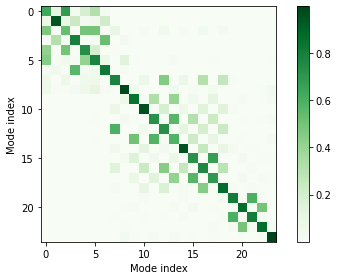

In [6]:
plt.imshow(abs(Ud), cmap="Greens")
plt.colorbar()
plt.xlabel("Mode index")
plt.ylabel("Mode index")
plt.tight_layout()
plt.show()

In [7]:
_, U1, r, U2, alpha = qchem.vibronic.gbs_params(wi, wf, Ud, delta)

In [10]:
np.random.seed(seed=1919)
n_samples = 5
n_modes = len(alpha)
eng = sf.LocalEngine(backend="gaussian")
gbs = sf.Program(n_modes)

with gbs.context as q:
    qchem.vibronic.VibronicTransition(U1, r, U2, alpha) | q
    sf.ops.MeasureFock() | q
samples = eng.run(gbs, shots=n_samples).samples.tolist()

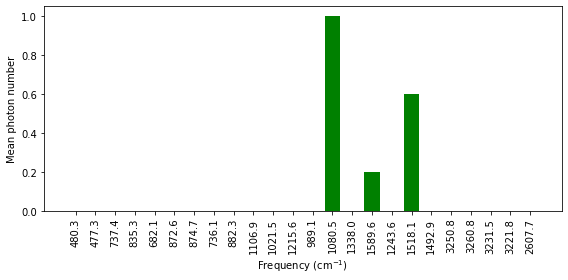

In [11]:
n_mean = np.mean(samples, axis=0)

plt.figure(figsize=(8, 4))
plt.ylabel("Mean photon number")
plt.xlabel(r"Frequency (cm$^{-1}$)")
plt.xticks(range(len(wf)), np.round(wf, 1), rotation=90)
plt.bar(range(len(wf)), n_mean, color="green")
plt.tight_layout()
plt.show()


In [12]:
np.random.seed(seed=1919)
n_samples = 5
n_modes = len(alpha)
eng = sf.LocalEngine(backend="gaussian")
gbs = sf.Program(n_modes)

with gbs.context as q:
    sf.ops.Dgate(1) | q[19]
    qchem.vibronic.VibronicTransition(U1, r, U2, alpha) | q
    sf.ops.MeasureFock() | q
samples = eng.run(gbs, shots=n_samples).samples.tolist()

/Users/Eden/opt/anaconda3/envs/quantum-computing/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator


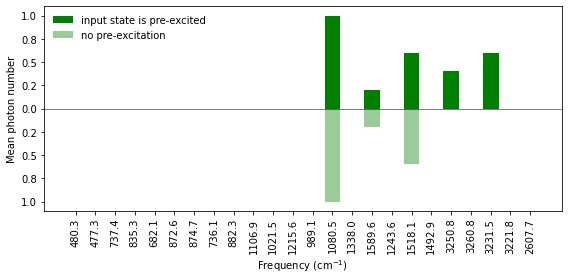

In [13]:
n_meanx = np.mean(samples, axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
plt.ylabel("Mean photon number")
plt.xlabel(r"Frequency (cm$^{-1}$)")
plt.ylim(-1.1, 1.1)
ax.set_yticklabels([(abs(tick)) for tick in np.round(ax.get_yticks(), 1)])
ax.axhline(0, color="black", lw=0.5)
plt.xticks(range(len(wf)), np.round(wf, 1), rotation=90)
plt.bar(range(len(wf)), n_meanx, color="green", label=("input state is pre-excited"))
plt.xticks(range(len(wf)), np.round(wf, 1), rotation=90)
plt.bar(range(len(wf)), -n_mean, color="green", alpha=0.4, label=("no pre-excitation"))
plt.legend(frameon=False, loc=2)
plt.tight_layout()
plt.show()